In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import os
from postalcodes_ca import fsa_codes
import datetime
from scipy.optimize import curve_fit
import folium
from folium import GeoJson

Reading file of transactions

In [2]:
df = pd.read_csv(r'C:\Users\mwendwa.kiko\Documents\Personal_Kiko\Old_UofT\Research\TraderCanada\AutoTrader_Data\univ-of-toronto\UnivOfToronto_Delistings_20240417132304.csv')

In [3]:
df.head()

,yr_month,Seller_FSA,Seller_Type,year,make,model,Fuel_Type,price_10k_bucket,Body_type,condition,delisted_ads
0,202012,T6B,Dealer,NaN,BMW,M,GasolineFuel,14,Sedan,New,1
1,202012,M5A,Dealer,NaN,Lexus,ES,Gas,0,Sedan,New,1
2,202010,L3R,Dealer,NaN,Lexus,ES,PremiumUnleaded,6,NaN,New,3
3,202011,V3H,Dealer,NaN,Lexus,IS,NaN,4,NaN,New,1
4,202012,M5A,Dealer,NaN,Lexus,IS,NaN,4,Sedan,New,1


In [4]:
df['year_grouped'] = df['year'].apply(lambda x: '1900-2005' if x <= 2005 else 
                                                    ('2006-2010' if x <= 2010 else ('2011-2015' if x <= 2016 else 
                                                                                    ('2017-2020' if x <= 2020 else 
                                                                                     '2021-2024'))))

In [5]:
df['yr_month_dtype'] = pd.to_datetime(df['yr_month'], format='%Y%m')
df['yr_month_dtype']

0          2020-12-01
1          2020-12-01
2          2020-10-01
3          2020-11-01
4          2020-12-01
              ...    
15175927   2024-02-01
15175928   2023-08-01
15175929   2023-11-01
15175930   2024-03-01
15175931   2024-02-01
Name: yr_month_dtype, Length: 15175932, dtype: datetime64[ns]

In [6]:
list_fsas_all = list(fsa_codes.keys())
len(list_fsas_all)

1651

In [7]:
df['Seller_FSA'] = df['Seller_FSA'].replace({'BH2': 'B2H', 'NOR': 'N0R'}).str.upper()

# Drop all rows with wrong fsas
df = df[df['Seller_FSA'].isin(list_fsas_all)]
df

,yr_month,Seller_FSA,Seller_Type,year,make,model,Fuel_Type,price_10k_bucket,Body_type,condition,delisted_ads,year_grouped,yr_month_dtype
0,202012,T6B,Dealer,NaN,BMW,M,GasolineFuel,14,Sedan,New,1,2021-2024,2020-12-01
1,202012,M5A,Dealer,NaN,Lexus,ES,Gas,0,Sedan,New,1,2021-2024,2020-12-01
2,202010,L3R,Dealer,NaN,Lexus,ES,PremiumUnleaded,6,NaN,New,3,2021-2024,2020-10-01
3,202011,V3H,Dealer,NaN,Lexus,IS,NaN,4,NaN,New,1,2021-2024,2020-11-01
4,202012,M5A,Dealer,NaN,Lexus,IS,NaN,4,Sedan,New,1,2021-2024,2020-12-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15175927,202402,J8C,Dealer,2024.0,Volvo,XC40RechargePureElectric,Electric,7,SUV,New,8,2021-2024,2024-02-01
15175928,202308,J8C,Dealer,2024.0,Volvo,XC40RechargePureElectric,Electric,7,SUV,New,2,2021-2024,2023-08-01
15175929,202311,B3K,Dealer,2024.0,Volvo,XC40RechargePureElectric,Electric,7,SUV,New,1,2021-2024,2023-11-01
15175930,202403,P7B,Dealer,2025.0,Ram,1500,Gas,0,Truck,New,3,2021-2024,2024-03-01


In [8]:
df['Standard_fuel_types'] = df['Fuel_Type'].replace({'Gasoline': 'ICEV', 'Gas': 'ICEV', 'GasolineFuel': 'ICEV', 'Diesel': 'Diesel', 
                                                     'PremiumUnleaded': 'ICEV', 'RegularUnleaded': 'ICEV', 'GasolineHybrid': 'HEV',
                                                     'Flexible': 'Flexible', 'Electric': 'BEV', 'Gas/ElectricHybrid': 'HEV', 'DieselFuel': 'Diesel',
                                                     'Gasoline - Hybrid': 'HEV', 'PremiumUnleaded91Octane': 'ICEV', 'Compressed Natural Gas': 'AFV', 
                                                     'Gasoline-Hybrid': 'HEV', 'E85-Gasoline(FlexFuel)': 'Flexible', 'Gasoline Fuel': 'ICEV', 'CompressedNaturalGas': 'AFV',
                                                      'Propane': 'AFV', 'E85- Gasoline(Flex Fuel)': 'Flexible', 'Premium Unleaded 91 Octane': 'ICEV', 'Premium Unleaded': 'ICEV',
                                                      'GaseousFuelCompatible': 'AFV', 'Regular Unleaded': 'ICEV', 'Gaseous Fuel Compatible': 'AFV', 'FlexFuelCapability': 'Flexible',
                                                      'Diesel Fuel': 'Diesel', 'Flex Fuel Capability': 'Flexible', 'NaturalGas': 'AFV', 'Gas/Electric Hybrid': 'HEV', 'Gasoline Hybrid': 'HEV',
                                                      'E85 - Gasoline (Flex Fuel)': 'Flexible', 'Natural Gas': 'AFV'
                                                     })

Filtering out new only

In [9]:
df_new = df.loc[df['condition'] == 'New']
df_new

,yr_month,Seller_FSA,Seller_Type,year,make,model,Fuel_Type,price_10k_bucket,Body_type,condition,delisted_ads,year_grouped,yr_month_dtype,Standard_fuel_types
0,202012,T6B,Dealer,NaN,BMW,M,GasolineFuel,14,Sedan,New,1,2021-2024,2020-12-01,ICEV
1,202012,M5A,Dealer,NaN,Lexus,ES,Gas,0,Sedan,New,1,2021-2024,2020-12-01,ICEV
2,202010,L3R,Dealer,NaN,Lexus,ES,PremiumUnleaded,6,NaN,New,3,2021-2024,2020-10-01,ICEV
3,202011,V3H,Dealer,NaN,Lexus,IS,NaN,4,NaN,New,1,2021-2024,2020-11-01,NaN
4,202012,M5A,Dealer,NaN,Lexus,IS,NaN,4,Sedan,New,1,2021-2024,2020-12-01,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15175927,202402,J8C,Dealer,2024.0,Volvo,XC40RechargePureElectric,Electric,7,SUV,New,8,2021-2024,2024-02-01,BEV
15175928,202308,J8C,Dealer,2024.0,Volvo,XC40RechargePureElectric,Electric,7,SUV,New,2,2021-2024,2023-08-01,BEV
15175929,202311,B3K,Dealer,2024.0,Volvo,XC40RechargePureElectric,Electric,7,SUV,New,1,2021-2024,2023-11-01,BEV
15175930,202403,P7B,Dealer,2025.0,Ram,1500,Gas,0,Truck,New,3,2021-2024,2024-03-01,ICEV


In [10]:
bev_new = df_new.loc[df_new['Standard_fuel_types'] == 'BEV']
bev_new

,yr_month,Seller_FSA,Seller_Type,year,make,model,Fuel_Type,price_10k_bucket,Body_type,condition,delisted_ads,year_grouped,yr_month_dtype,Standard_fuel_types
359,202012,M9B,Dealer,NaN,Volvo,XC90,Electric,8,NaN,New,1,2021-2024,2020-12-01,BEV
363,202006,V1X,Dealer,NaN,MINI,3Door,Electric,4,Hatchback,New,1,2021-2024,2020-06-01,BEV
779,202011,H8N,Dealer,NaN,Kia,SoulEV,Electric,5,Wagon,New,1,2021-2024,2020-11-01,BEV
780,202011,V3Y,Dealer,NaN,Kia,SoulEV,Electric,5,Hatchback,New,1,2021-2024,2020-11-01,BEV
782,202011,H7T,Dealer,NaN,Kia,SoulEV,Electric,5,Wagon,New,1,2021-2024,2020-11-01,BEV
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15175925,202402,L3Y,Dealer,2024.0,Volvo,C40RechargePureElectric,Electric,8,SUV,New,1,2021-2024,2024-02-01,BEV
15175926,202401,J1L,Dealer,2024.0,Volvo,XC40RechargePureElectric,Electric,6,SUV,New,1,2021-2024,2024-01-01,BEV
15175927,202402,J8C,Dealer,2024.0,Volvo,XC40RechargePureElectric,Electric,7,SUV,New,8,2021-2024,2024-02-01,BEV
15175928,202308,J8C,Dealer,2024.0,Volvo,XC40RechargePureElectric,Electric,7,SUV,New,2,2021-2024,2023-08-01,BEV


In [11]:
# Monthly counts of new BEV listings using yr_month_dtype
bev_monthly_counts = bev_new['yr_month_dtype'].value_counts().sort_index()
bev_monthly_counts.index = bev_monthly_counts.index.to_period('M')
bev_monthly_counts

yr_month_dtype
2016-01      46
2016-02      41
2016-03      49
2016-04      64
2016-05      45
           ... 
2023-11    1666
2023-12    1713
2024-01    1706
2024-02    1840
2024-03    2131
Freq: M, Name: count, Length: 99, dtype: int64

So not a lot per month. 

In [12]:
tesla_data_2019_23 = pd.read_csv('izev_data\\izev_tesla_purchases_2021-01_to_2024-03_2019-2023_izev_data.csv')
tesla_data_2019_23

,Incentive Request Date,Month and Year,Government of Canada Fiscal Year (FY),Calendar Year,Dealership Province/Territory,Dealership Postal Code,Purchase or Lease,Vehicle Year,Vehicle Make,Vehicle Model,Vehicle Make and Model,"Battery, Plug-in Hybrid, or Fuel Cell EV (BEV, PHEV or FCEV)",BEV/PHEV/FCEV - Battery ≥ 15kWh or electric range ≥ 50km,Battery/Electric Range Criteria Pre/Since 2022-04-25,Eligible Incentive Amount (in dollars),Individual or Organization (Recipient),Recipient Province/Territory,Country
0,2021-01-11,January 2021,2020-21,2021.0,British Columbia,V5L,Purchase,2021.0,Tesla,Model 3,Tesla Model 3,BEV,YES,BEV,"5,000",Individual,Ontario,Canada
1,2021-01-11,January 2021,2020-21,2021.0,British Columbia,V5L,Purchase,2021.0,Tesla,Model 3,Tesla Model 3,BEV,YES,BEV,"5,000",Individual,Ontario,Canada
2,2021-01-11,January 2021,2020-21,2021.0,British Columbia,V5L,Purchase,2021.0,Tesla,Model 3,Tesla Model 3,BEV,YES,BEV,"5,000",Individual,Quebec,Canada
3,2021-01-11,January 2021,2020-21,2021.0,British Columbia,V5L,Purchase,2021.0,Tesla,Model 3,Tesla Model 3,BEV,YES,BEV,"5,000",Individual,Ontario,Canada
4,2021-01-11,January 2021,2020-21,2021.0,British Columbia,V5L,Purchase,2021.0,Tesla,Model 3,Tesla Model 3,BEV,YES,BEV,"5,000",Individual,Quebec,Canada
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25332,2023-03-29,March 2023,2022-23,2023.0,British Columbia,V5L,Purchase,2023.0,Tesla,Model 3,Tesla Model 3,BEV,YES,BEV,"5,000",Individual,Ontario,Canada
25333,2023-03-29,March 2023,2022-23,2023.0,British Columbia,V5L,Purchase,2023.0,Tesla,Model 3,Tesla Model 3,BEV,YES,BEV,"5,000",Individual,Ontario,Canada
25334,2023-03-29,March 2023,2022-23,2023.0,British Columbia,V5L,Purchase,2023.0,Tesla,Model 3,Tesla Model 3,BEV,YES,BEV,"5,000",Individual,Quebec,Canada
25335,2023-03-29,March 2023,2022-23,2023.0,British Columbia,V5L,Purchase,2023.0,Tesla,Model 3,Tesla Model 3,BEV,YES,BEV,"5,000",Organization,Ontario,Canada


In [13]:
tesla_data_2023_24 = pd.read_csv('izev_data\\izev_tesla_purchases_2021-01_to_2024-03_2021-2024_izev_data.csv')
tesla_data_2023_24

,Incentive Request Date,Month and Year,Government of Canada Fiscal Year (FY),Calendar Year,Dealership Province/Territory,Dealership Postal Code,Purchase or Lease,Vehicle Year,Vehicle Make,Vehicle Model,Vehicle Make and Model,"Battery, Plug-in Hybrid, or Fuel Cell EV (BEV, PHEV or FCEV)",BEV/PHEV/FCEV - Battery ≥ 15kWh or electric range ≥ 50km,Battery/Electric Range Criteria Pre/Since 2022-04-25,Eligible Incentive Amount (in dollars),Individual or Organization (Recipient),Recipient Province/Territory,Country
0,2023-04-06,April 2023,2023-24,2023.0,British Columbia,V5L,Purchase,2023.0,Tesla,Model 3,Tesla Model 3,BEV,YES,BEV,"5,000",Individual,Quebec,Canada
1,2023-04-06,April 2023,2023-24,2023.0,British Columbia,V5L,Purchase,2023.0,Tesla,Model 3,Tesla Model 3,BEV,YES,BEV,"5,000",Individual,Quebec,Canada
2,2023-04-06,April 2023,2023-24,2023.0,British Columbia,V5L,Purchase,2023.0,Tesla,Model 3,Tesla Model 3,BEV,YES,BEV,"5,000",Individual,Ontario,Canada
3,2023-04-06,April 2023,2023-24,2023.0,British Columbia,V5L,Purchase,2023.0,Tesla,Model 3,Tesla Model 3,BEV,YES,BEV,"5,000",Individual,Quebec,Canada
4,2023-04-06,April 2023,2023-24,2023.0,British Columbia,V5L,Purchase,2023.0,Tesla,Model 3,Tesla Model 3,BEV,YES,BEV,"5,000",Individual,Quebec,Canada
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44333,2024-03-31,March 2024,2023-24,2024.0,British Columbia,V5L,Purchase,2024.0,Tesla,Model Y,Tesla Model Y,BEV,YES,BEV,"5,000",Individual,British Columbia,Canada
44334,2024-03-31,March 2024,2023-24,2024.0,British Columbia,V5L,Purchase,2024.0,Tesla,Model Y,Tesla Model Y,BEV,YES,BEV,"5,000",Individual,British Columbia,Canada
44335,2024-03-31,March 2024,2023-24,2024.0,British Columbia,V5L,Purchase,2024.0,Tesla,Model Y,Tesla Model Y,BEV,YES,BEV,"5,000",Individual,British Columbia,Canada
44336,2024-03-31,March 2024,2023-24,2024.0,British Columbia,V5L,Purchase,2024.0,Tesla,Model Y,Tesla Model Y,BEV,YES,BEV,"5,000",Individual,Ontario,Canada


In [14]:
tesla_17_20 = pd.read_csv('izev_data\\izev_tesla_purchases_2017-2020_2016-2024_2019-23_izev_data_b.csv')
tesla_17_20

,Incentive Request Date,Month and Year,Government of Canada Fiscal Year (FY),Calendar Year,Dealership Province/Territory,Dealership Postal Code,Purchase or Lease,Vehicle Year,Vehicle Make,Vehicle Model,Vehicle Make and Model,"Battery, Plug-in Hybrid, or Fuel Cell EV (BEV, PHEV or FCEV)",BEV/PHEV/FCEV - Battery ≥ 15kWh or electric range ≥ 50km,Battery/Electric Range Criteria Pre/Since 2022-04-25,Eligible Incentive Amount (in dollars),Individual or Organization (Recipient),Recipient Province/Territory,Country
0,2019-05-17,May 2019,2019-20,2019.0,Quebec,J0B,Purchase,2019.0,Tesla,Model 3,Tesla Model 3,BEV,YES,BEV,"5,000",Individual,Quebec,Canada
1,2019-05-17,May 2019,2019-20,2019.0,Quebec,J0B,Purchase,2019.0,Tesla,Model 3,Tesla Model 3,BEV,YES,BEV,"5,000",Organization,Quebec,Canada
2,2019-05-18,May 2019,2019-20,2019.0,British Columbia,V5L,Purchase,2019.0,Tesla,Model 3,Tesla Model 3,BEV,YES,BEV,"5,000",Individual,British Columbia,Canada
3,2019-05-20,May 2019,2019-20,2019.0,British Columbia,V5L,Purchase,2019.0,Tesla,Model 3,Tesla Model 3,BEV,YES,BEV,"5,000",Individual,British Columbia,Canada
4,2019-05-20,May 2019,2019-20,2019.0,British Columbia,V5L,Purchase,2019.0,Tesla,Model 3,Tesla Model 3,BEV,YES,BEV,"5,000",Individual,British Columbia,Canada
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18810,2022-06-21,June 2022,2022-23,2022.0,British Columbia,V5L,Purchase,2020.0,Tesla,Model 3,Tesla Model 3,BEV,YES,BEV,"5,000",Organization,Ontario,Canada
18811,2022-06-23,June 2022,2022-23,2022.0,British Columbia,V5L,Purchase,2020.0,Tesla,Model 3,Tesla Model 3,BEV,YES,BEV,"5,000",Individual,Manitoba,Canada
18812,2022-07-19,July 2022,2022-23,2022.0,British Columbia,V5L,Purchase,2020.0,Tesla,Model 3,Tesla Model 3,BEV,YES,BEV,"5,000",Individual,Alberta,Canada
18813,2022-08-22,August 2022,2022-23,2022.0,British Columbia,V5L,Purchase,2020.0,Tesla,Model 3,Tesla Model 3,BEV,YES,BEV,"5,000",Individual,Ontario,Canada


In [15]:
# Monthly counts of tesla purchases from 2017-2020
tesla_17_20['purchase_yr_month_dtype'] = pd.to_datetime(tesla_17_20['Incentive Request Date'])
tesla_17_20_monthly_counts = tesla_17_20.resample('M', on='purchase_yr_month_dtype').size()
tesla_17_20_monthly_counts.index = tesla_17_20_monthly_counts.index.to_period('M')
tesla_17_20_monthly_counts

C:\Users\mwendwa.kiko\AppData\Local\Temp\ipykernel_19484\3901289214.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  tesla_17_20_monthly_counts = tesla_17_20.resample('M', on='purchase_yr_month_dtype').size()


purchase_yr_month_dtype
2019-05     247
2019-06    2315
2019-07    1224
2019-08    1287
2019-09    1673
2019-10     398
2019-11     602
2019-12     773
2020-01    1078
2020-02     823
2020-03    1648
2020-04     351
2020-05     240
2020-06    1593
2020-07     411
2020-08     367
2020-09     329
2020-10    1479
2020-11     760
2020-12      71
2021-01       3
2021-02      35
2021-03       1
2021-04       1
2021-05       0
2021-06       0
2021-07       1
2021-08     913
2021-09     167
2021-10       0
2021-11       0
2021-12       0
2022-01       1
2022-02       0
2022-03       0
2022-04      12
2022-05       6
2022-06       3
2022-07       1
2022-08       1
2022-09       0
2022-10       1
Freq: M, dtype: int64

In [16]:
tesla_data_2019_23['purchase_yr_month_dtype'] = pd.to_datetime(tesla_data_2019_23['Incentive Request Date'])
tesla_2019_23_monthly_counts = tesla_data_2019_23.resample('M', on='purchase_yr_month_dtype').size()
# Make index yr and month only
tesla_2019_23_monthly_counts.index = tesla_2019_23_monthly_counts.index.to_period('M')
tesla_2019_23_monthly_counts

C:\Users\mwendwa.kiko\AppData\Local\Temp\ipykernel_19484\1890216858.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  tesla_2019_23_monthly_counts = tesla_data_2019_23.resample('M', on='purchase_yr_month_dtype').size()


purchase_yr_month_dtype
2021-01      11
2021-02    1568
2021-03     886
2021-04     579
2021-05     386
2021-06    1526
2021-07     696
2021-08    1334
2021-09    1629
2021-10    3512
2021-11     654
2021-12      32
2022-01     226
2022-02    3364
2022-03    1529
2022-04     268
2022-05    1050
2022-06     176
2022-07     482
2022-08    2091
2022-09    1064
2022-10      64
2022-11      18
2022-12       6
2023-01       0
2023-02     819
2023-03    1367
Freq: M, dtype: int64

In [17]:
tesla_data_2023_24['purchase_yr_month_dtype'] = pd.to_datetime(tesla_data_2023_24['Incentive Request Date'])
tesla_2023_24_monthly_counts = tesla_data_2023_24.resample('M', on='purchase_yr_month_dtype').size()
# Make index yr and month only
tesla_2023_24_monthly_counts.index = tesla_2023_24_monthly_counts.index.to_period('M')
tesla_2023_24_monthly_counts

C:\Users\mwendwa.kiko\AppData\Local\Temp\ipykernel_19484\820050586.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  tesla_2023_24_monthly_counts = tesla_data_2023_24.resample('M', on='purchase_yr_month_dtype').size()


purchase_yr_month_dtype
2023-04     714
2023-05     786
2023-06    2676
2023-07       0
2023-08    8252
2023-09    7253
2023-10    4531
2023-11    5572
2023-12    5671
2024-01     814
2024-02    3051
2024-03    5018
Freq: M, dtype: int64

In [18]:
# Merge bev_monthly_counts and all tesla monthly counts into a single dataframe for comparison
comparison_df = pd.DataFrame({
    'BEV_New_Listings': bev_monthly_counts,
    'Tesla_2017_2020_Purchases': tesla_17_20_monthly_counts,
    'Tesla_2019_2023_Purchases': tesla_2019_23_monthly_counts,
    'Tesla_2021_2024_Purchases': tesla_2023_24_monthly_counts
}).fillna(0).astype(int)
comparison_df

,BEV_New_Listings,Tesla_2017_2020_Purchases,Tesla_2019_2023_Purchases,Tesla_2021_2024_Purchases
2016-01,46,0,0,0
2016-02,41,0,0,0
2016-03,49,0,0,0
2016-04,64,0,0,0
2016-05,45,0,0,0
...,...,...,...,...
2023-11,1666,0,0,5572
2023-12,1713,0,0,5671
2024-01,1706,0,0,814
2024-02,1840,0,0,3051


In [19]:
bev_totals = comparison_df.sum(axis=1)
bev_totals

2016-01      46
2016-02      41
2016-03      49
2016-04      64
2016-05      45
           ... 
2023-11    7238
2023-12    7384
2024-01    2520
2024-02    4891
2024-03    7149
Freq: M, Length: 99, dtype: int64

In [20]:


# Convert monthly PeriodIndex -> DatetimeIndex
bev_dt = bev_totals.to_timestamp()  # preserves end-of-month timestamps

# Resample to 3-month totals (blocks aligned to calendar month boundaries)
bev_totals_3m = bev_dt.resample('3M').sum().to_period('M')
bev_totals_3m

C:\Users\mwendwa.kiko\AppData\Local\Temp\ipykernel_19484\3497668072.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  bev_totals_3m = bev_dt.resample('3M').sum().to_period('M')


2016-01       46
2016-04      154
2016-07      151
2016-10      212
2017-01      212
2017-04      355
2017-07      451
2017-10      439
2018-01      510
2018-04      657
2018-07      694
2018-10      643
2019-01      710
2019-04      776
2019-07     4964
2019-10     4401
2020-01     3644
2020-04     3862
2020-07     3462
2020-10     3846
2021-01     2225
2021-04     5097
2021-07     4990
2021-10     9631
2022-01     2283
2022-04     6756
2022-07     3270
2022-10     5190
2023-01     1989
2023-04     5505
2023-07     7454
2023-10    25268
2024-01    17142
2024-04    12040
Freq: M, dtype: int64

Comparison dataset: Statscan Registrations Data

In [21]:
statscan_reg_data = pd.read_csv(r'statscan_registration_data\20100025.csv')
statscan_reg_data.head()

C:\Users\mwendwa.kiko\AppData\Local\Temp\ipykernel_19484\928463827.py:1: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  statscan_reg_data = pd.read_csv(r'statscan_registration_data\20100025.csv')


,REF_DATE,GEO,DGUID,Fuel type,Vehicle type,Statistics,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
0,2017-01,Canada,2021A000011124,All fuel types,"Total, vehicle type",Number of vehicles,Units,300,units,0,v1671330686,1.4.1.1,425031.0,NaN,NaN,NaN,0
1,2017-01,Canada,2021A000011124,All fuel types,Passenger cars,Number of vehicles,Units,300,units,0,v1671330687,1.4.2.1,130740.0,NaN,NaN,NaN,0
2,2017-01,Canada,2021A000011124,All fuel types,Pickup trucks,Number of vehicles,Units,300,units,0,v1671330688,1.4.3.1,89794.0,NaN,NaN,NaN,0
3,2017-01,Canada,2021A000011124,All fuel types,Multi-purpose vehicles,Number of vehicles,Units,300,units,0,v1671330689,1.4.4.1,176932.0,NaN,NaN,NaN,0
4,2017-01,Canada,2021A000011124,All fuel types,Vans,Number of vehicles,Units,300,units,0,v1671330690,1.4.5.1,27565.0,NaN,NaN,NaN,0


In [22]:
statscan_reg_data['Vehicle type'].unique()

array(['Total, vehicle type', 'Passenger cars', 'Pickup trucks',
       'Multi-purpose vehicles', 'Vans'], dtype=object)

In [23]:
fuel_type_cond = statscan_reg_data['Fuel type'] == 'Battery electric'
geo_cond = statscan_reg_data['GEO'] == 'Canada'
# vehicle_type_cond = statscan_reg_data['Vehicle type'] == 'Total, vehicle type'
vehicle_type_cond = statscan_reg_data['Vehicle type'].isin(['Passenger cars', 'Pickup trucks', 'Multi-purpose vehicles'])

canada_bev_data = statscan_reg_data[fuel_type_cond & geo_cond & vehicle_type_cond].reset_index()
canada_bev_data

,index,REF_DATE,GEO,DGUID,Fuel type,Vehicle type,Statistics,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
0,21,2017-01,Canada,2021A000011124,Battery electric,Passenger cars,Number of vehicles,Units,300,units,0,v1671330678,1.2.2.1,1133.0,NaN,NaN,NaN,0
1,22,2017-01,Canada,2021A000011124,Battery electric,Pickup trucks,Number of vehicles,Units,300,units,0,v1671330679,1.2.3.1,0.0,NaN,NaN,NaN,0
2,23,2017-01,Canada,2021A000011124,Battery electric,Multi-purpose vehicles,Number of vehicles,Units,300,units,0,v1671330680,1.2.4.1,531.0,NaN,NaN,NaN,0
3,213821,2017-04,Canada,2021A000011124,Battery electric,Passenger cars,Number of vehicles,Units,300,units,0,v1671330678,1.2.2.1,1653.0,NaN,NaN,NaN,0
4,213822,2017-04,Canada,2021A000011124,Battery electric,Pickup trucks,Number of vehicles,Units,300,units,0,v1671330679,1.2.3.1,0.0,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,7055422,2025-04,Canada,2021A000011124,Battery electric,Pickup trucks,Number of vehicles,Units,300,units,0,v1671330679,1.2.3.1,3523.0,NaN,NaN,NaN,0
101,7055423,2025-04,Canada,2021A000011124,Battery electric,Multi-purpose vehicles,Number of vehicles,Units,300,units,0,v1671330680,1.2.4.1,21652.0,NaN,NaN,NaN,0
102,7269221,2025-07,Canada,2021A000011124,Battery electric,Passenger cars,Number of vehicles,Units,300,units,0,v1671330678,1.2.2.1,3629.0,NaN,NaN,NaN,0
103,7269222,2025-07,Canada,2021A000011124,Battery electric,Pickup trucks,Number of vehicles,Units,300,units,0,v1671330679,1.2.3.1,3569.0,NaN,NaN,NaN,0


In [24]:
canada_bev_data['REF_DATE'] = pd.to_datetime(canada_bev_data['REF_DATE']).dt.to_period('M')
canada_bev_data['REF_DATE']

0      2017-01
1      2017-01
2      2017-01
3      2017-04
4      2017-04
        ...   
100    2025-04
101    2025-04
102    2025-07
103    2025-07
104    2025-07
Name: REF_DATE, Length: 105, dtype: period[M]

In [25]:
# canada_bev_data group by REF_DATE and sum VALUE for Vehicle type = Passenger cars or Pickup trucks

canada_bev_data_grouped = canada_bev_data.groupby('REF_DATE')['VALUE'].sum().reset_index()

canada_bev_data_merged = canada_bev_data_grouped.merge(bev_totals_3m.rename('BEV_Total_3M_Listings'), left_on='REF_DATE', right_index=True, how='left')
canada_bev_data_merged.head()

,REF_DATE,VALUE,BEV_Total_3M_Listings
0,2017-01,1664.0,212.0
1,2017-04,2197.0,355.0
2,2017-07,2401.0,451.0
3,2017-10,2824.0,439.0
4,2018-01,2639.0,510.0


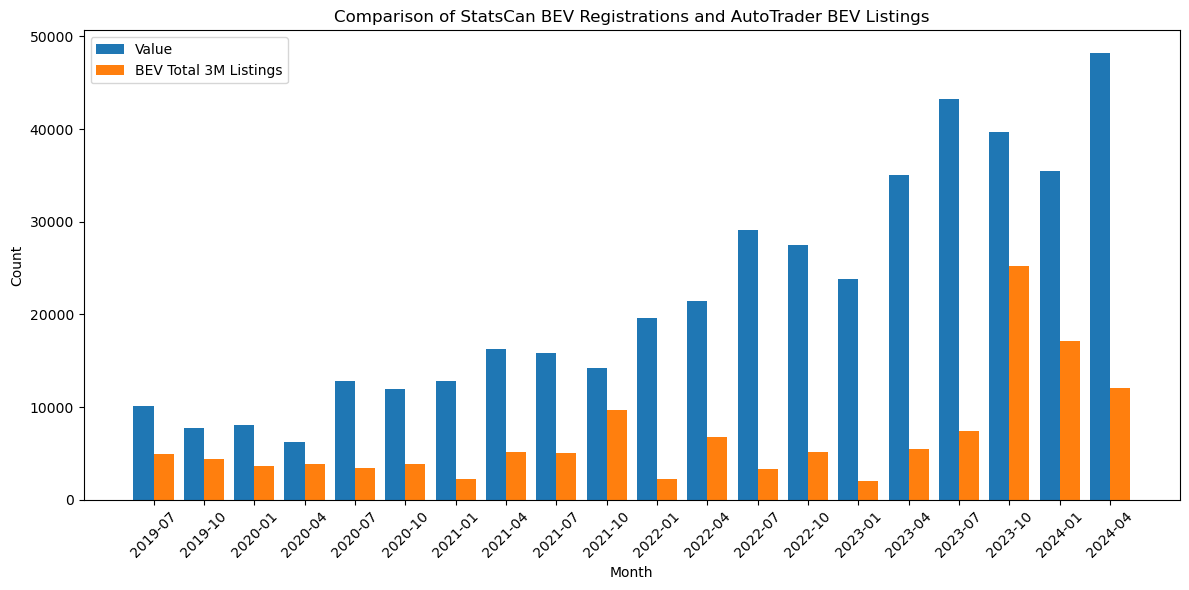

In [ ]:
# Drop before 2019-07 and after 2024-04
canada_bev_data_merged_plot = canada_bev_data_merged[(canada_bev_data_merged['REF_DATE'] >= pd.Period('2019-07', freq='M')) & 
                                                  (canada_bev_data_merged['REF_DATE'] <= pd.Period('2024-04', freq='M'))]

# Ensure chronological order
canada_bev_data_merged_plot = canada_bev_data_merged_plot.sort_values('REF_DATE')
# Handle PeriodDtype safely: convert to timestamps if needed
dates = canada_bev_data_merged_plot['REF_DATE']
if hasattr(dates, 'dtype') and str(dates.dtype).startswith('period'):
    dates_dt = dates.dt.to_timestamp()     # end-of-month timestamps by default
else:
    # Already datetime or string; coerce to datetime for consistent labeling
    dates_dt = pd.to_datetime(dates)

# Tick labels: Month-Year like '2024-03'
x_labels = dates_dt.dt.strftime('%Y-%m')

# X positions
x = np.arange(len(x_labels))
width = 0.4  # bar width

plt.figure(figsize=(12, 6))

# Side-by-side bars
plt.bar(x - width/2,
        canada_bev_data_merged_plot['VALUE'],
        width,
        label='Value',
        color='#1f77b4')
plt.bar(x + width/2,
        canada_bev_data_merged_plot['BEV_Total_3M_Listings'],
        width,
        label='BEV Total 3M Listings',
        color='#ff7f0e')

# Labels and formatting
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Comparison of StatsCan BEV Registrations and AutoTrader BEV Listings')
plt.xticks(x, x_labels, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()



In [70]:
canada_bev_data_merged[['VALUE', 'BEV_Total_3M_Listings']].sum()

VALUE                    439292.0
BEV_Total_3M_Listings    133019.0
dtype: float64

Saving to use for CI generation

In [31]:
canada_bev_data_merged['ZoneID'] = 'Canada'

In [32]:
canada_bev_data_merged['months_since_start'] = (canada_bev_data_merged['REF_DATE'].dt.year - canada_bev_data_merged['REF_DATE'].dt.year.min()) * 12 + (canada_bev_data_merged['REF_DATE'].dt.month - canada_bev_data_merged['REF_DATE'].dt.month.min())
canada_bev_data_merged['months_since_start']

0       0
1       3
2       6
3       9
4      12
5      15
6      18
7      21
8      24
9      27
10     30
11     33
12     36
13     39
14     42
15     45
16     48
17     51
18     54
19     57
20     60
21     63
22     66
23     69
24     72
25     75
26     78
27     81
28     84
29     87
30     90
31     93
32     96
33     99
34    102
Name: months_since_start, dtype: int64

In [33]:
canada_bev_data_train = canada_bev_data_merged[(canada_bev_data_merged['REF_DATE'] <= pd.Period('2024-04', freq='M'))]
canada_bev_data_val = canada_bev_data_merged[(canada_bev_data_merged['REF_DATE'] > pd.Period('2024-04', freq='M'))]

In [34]:
# Save to CSV
canada_bev_data_train.to_csv('canada_bev_data_train.csv', index=False)
canada_bev_data_val.to_csv('canada_bev_data_val.csv', index=False)